# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import random 
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/svnw-imperial-capstone/train_32x32.mat
/kaggle/input/svnw-imperial-capstone/test_32x32.mat


![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
train = loadmat('/kaggle/input/svnw-imperial-capstone/train_32x32.mat')
test = loadmat('/kaggle/input/svnw-imperial-capstone/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [3]:
print("train keys: ",train.keys())
print("test keys: ",test.keys())

train keys:  dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
test keys:  dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])


In [4]:
X_train = train['X']
y_train = train['y']
X_test = test['X']
y_test = test['y']
X_train.shape

(32, 32, 3, 73257)

In [5]:
X_train = np.transpose(X_train,(3,0,1,2))/255.
X_test = np.transpose(X_test,(3,0,1,2))/255.
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)

y_train = encoder.fit_transform(y_train % 10)
y_test = encoder.fit_transform(y_test % 10)

In [6]:
import random
import matplotlib.pyplot as plt

def random_imgs(x, y):
    num_samples = x.shape[0] 
    indexs = random.sample(range(0, num_samples + 1), 15)
    fig, axs = plt.subplots(nrows = 3, ncols = 5, figsize=(10,10))

    for idx, ax in zip(indexs, axs.flatten()):
        if(x[idx].shape == (32,32,3)):
            ax.imshow(x[idx])
        else:
            ax.imshow(x[idx,...,0],cmap='gray')
        ax.set_xlabel(str(np.argmax(y[idx])))
        

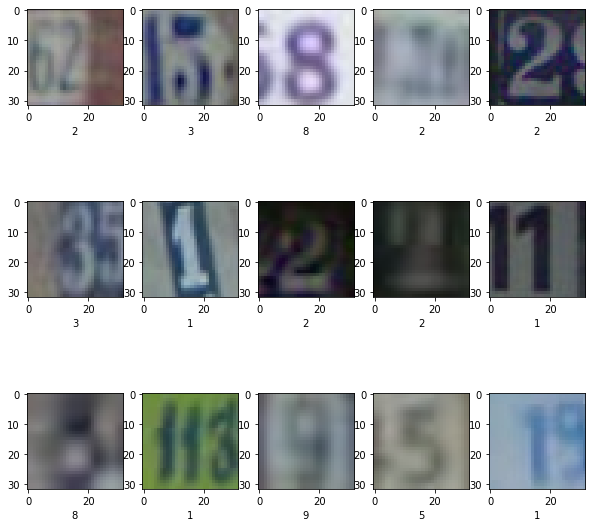

In [7]:
random_imgs(X_train,y_train)

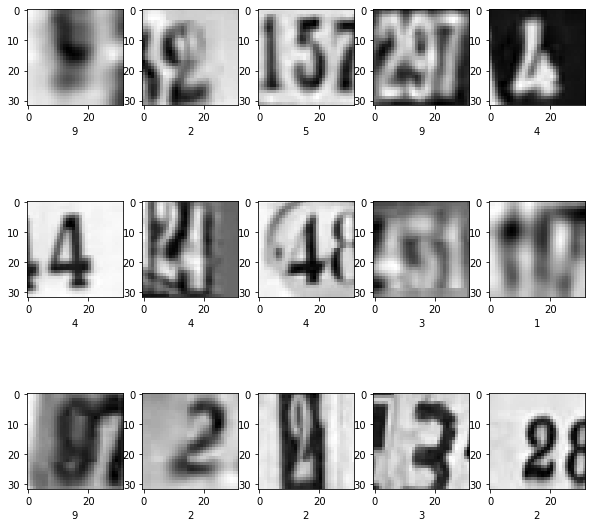

In [8]:
def rgb2grey(img):
        return np.dot(img, [0.2989, 0.5870, 0.1140])[...,np.newaxis]
    
X_train_grey = rgb2grey(X_train).astype(np.float32)
X_test_grey = rgb2grey(X_test).astype(np.float32)
random_imgs(X_train_grey,y_train)

In [9]:
from sklearn.model_selection import train_test_split

train_x , valid_x , train_y , valid_y = train_test_split(X_train_grey,y_train, test_size = 0.05)

In [10]:
train_x.shape

(69594, 32, 32, 1)

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,BatchNormalization, MaxPooling2D,Conv2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers

In [12]:
def get_model(input_shape):
    
    model=Sequential([
        Flatten( input_shape = (input_shape), name="Flatten_Layer_1"),
        Dense(64, activation ='relu', name="Dense_Layer_1"),
        Dense(64, activation = 'relu', name="Dense_Layer_2"),
        Dense(64, activation = 'relu', name="Dense_Layer_3"),
        Dense(10, activation = 'softmax', name="Output_Layer")
    ])
    
    model.compile(optimizer = 'sgd',
                 loss = 'categorical_crossentropy',
                 metrics = ['accuracy'])
    
    return model

In [13]:
model = get_model(train_x[0].shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten_Layer_1 (Flatten)    (None, 1024)              0         
_________________________________________________________________
Dense_Layer_1 (Dense)        (None, 64)                65600     
_________________________________________________________________
Dense_Layer_2 (Dense)        (None, 64)                4160      
_________________________________________________________________
Dense_Layer_3 (Dense)        (None, 64)                4160      
_________________________________________________________________
Output_Layer (Dense)         (None, 10)                650       
Total params: 74,570
Trainable params: 74,570
Non-trainable params: 0
_________________________________________________________________


2022-06-28 17:18:50.854165: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [14]:
def get_checkpoint_best_only():
    
    checkpoint_path_best_only = 'checkpoints_best_only/checkpoint'
    checkpoints_best_only = ModelCheckpoint(filepath=checkpoint_path_best_only,
                                           save_weights_only=True,
                                           monitor='val_accuracy',
                                           frequency="epoch",
                                           save_best_only=True,
                                            verbose=1)
    return checkpoints_best_only



def get_early_stopping():

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                      patience=3,
                                                     verbose=1)
    return early_stopping

In [15]:
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()
callbacks = [checkpoint_best_only, early_stopping]

In [16]:
def train_model(model, train_data, train_targets, batch_size, epochs):
    
    history = model.fit(train_data, 
                        train_targets,
                        batch_size=batch_size,
                        epochs = epochs,
                        validation_data = (valid_x,valid_y),
                       callbacks = callbacks)
    return history

In [17]:
history = train_model(model, train_x, train_y, 16, 25)

2022-06-28 17:18:52.244252: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
4350/4350 [==============================] - 13s 3ms/step - loss: 2.0641 - accuracy: 0.2595 - val_loss: 1.7375 - val_accuracy: 0.3953

Epoch 00001: val_accuracy improved from -inf to 0.39530, saving model to checkpoints_best_only/checkpoint
Epoch 2/25
4350/4350 [==============================] - 10s 2ms/step - loss: 1.4903 - accuracy: 0.5039 - val_loss: 1.4306 - val_accuracy: 0.5121

Epoch 00002: val_accuracy improved from 0.39530 to 0.51215, saving model to checkpoints_best_only/checkpoint
Epoch 3/25
4350/4350 [==============================] - 10s 2ms/step - loss: 1.2442 - accuracy: 0.6010 - val_loss: 1.1664 - val_accuracy: 0.6320

Epoch 00003: val_accuracy improved from 0.51215 to 0.63200, saving model to checkpoints_best_only/checkpoint
Epoch 4/25
4350/4350 [==============================] - 10s 2ms/step - loss: 1.1166 - accuracy: 0.6477 - val_loss: 1.1331 - val_accuracy: 0.6435

Epoch 00004: val_accuracy improved from 0.63200 to 0.64346, saving model to checkpoints_best

In [18]:
def get_test_accuracy(model, X_test_grey, y_test):
    test_loss, test_acc = model.evaluate(x=X_test_grey, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

In [19]:
get_test_accuracy(model, X_test_grey, y_test)

accuracy: 0.761


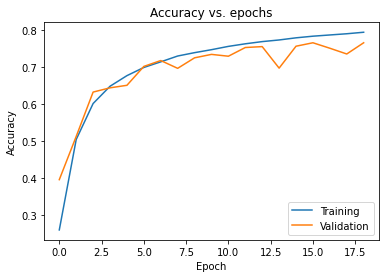

In [20]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

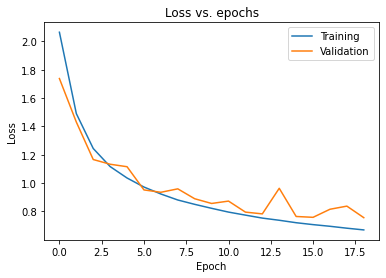

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [22]:
def get_conv_model(input_shape, dropout_rate, wd):
    
    conv_model=Sequential([
        Conv2D(16, kernel_size=(3,3), activation='relu',kernel_regularizer=regularizers.l2(wd), input_shape = (input_shape),name="Conv_Layer_1"),
        Conv2D(16, kernel_size=(3,3), activation='relu', name="Conv_Layer_2"),
        MaxPooling2D((2,2), name="Max_Pool"),
        Flatten(name="Flatten_Layer_1"),
        Dropout(dropout_rate),
        BatchNormalization(),
        Dense(8, activation = 'relu', name="Dense_Layer_1"),
        Dense(8, activation = 'relu', name="Dense_Layer_2"),
        Dense(10, activation = 'softmax', name="Output_Layer")
    ])
    
    conv_model.compile(optimizer = 'adam',
                 loss = 'categorical_crossentropy',
                 metrics = ['accuracy'])
    
    return conv_model

In [23]:
conv_model = get_conv_model(train_x[0].shape, 0.25, 0.001)
conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_Layer_1 (Conv2D)        (None, 30, 30, 16)        160       
_________________________________________________________________
Conv_Layer_2 (Conv2D)        (None, 28, 28, 16)        2320      
_________________________________________________________________
Max_Pool (MaxPooling2D)      (None, 14, 14, 16)        0         
_________________________________________________________________
Flatten_Layer_1 (Flatten)    (None, 3136)              0         
_________________________________________________________________
dropout (Dropout)            (None, 3136)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3136)              12544     
_________________________________________________________________
Dense_Layer_1 (Dense)        (None, 8)                

In [24]:
def get_checkpoint_best_only_conv():
    
    checkpoint_path_best_only_conv = 'checkpoints_best_only/checkpoint'
    checkpoints_best_only_conv = ModelCheckpoint(filepath=checkpoint_path_best_only_conv,
                                           save_weights_only=True,
                                           monitor='val_accuracy',
                                           frequency="epoch",
                                           save_best_only=True,
                                            verbose=1)
    return checkpoints_best_only_conv



def get_early_stopping_conv():

    early_stopping_conv = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                      patience=5,
                                                     verbose=1)
    return early_stopping_conv

In [25]:
checkpoint_best_only_conv = get_checkpoint_best_only_conv()
early_stopping_conv = get_early_stopping_conv()
callbacks_conv = [checkpoint_best_only_conv, early_stopping_conv]

In [26]:
def train_model(conv_model, train_data, train_targets, batch_size, epochs):
    
    history_conv = conv_model.fit(train_data, 
                        train_targets,
                        batch_size=batch_size,
                        epochs = epochs,
                        validation_data = (valid_x,valid_y),
                        callbacks=callbacks_conv)
    return history_conv
history_conv = train_model(conv_model, train_x, train_y,16, 20)

Epoch 1/20
4350/4350 [==============================] - 35s 8ms/step - loss: 1.3144 - accuracy: 0.5483 - val_loss: 0.8091 - val_accuracy: 0.7535

Epoch 00001: val_accuracy improved from -inf to 0.75348, saving model to checkpoints_best_only/checkpoint
Epoch 2/20
4350/4350 [==============================] - 34s 8ms/step - loss: 0.8649 - accuracy: 0.7191 - val_loss: 0.6750 - val_accuracy: 0.7950

Epoch 00002: val_accuracy improved from 0.75348 to 0.79498, saving model to checkpoints_best_only/checkpoint
Epoch 3/20
4350/4350 [==============================] - 34s 8ms/step - loss: 0.7879 - accuracy: 0.7468 - val_loss: 0.6626 - val_accuracy: 0.8051

Epoch 00003: val_accuracy improved from 0.79498 to 0.80508, saving model to checkpoints_best_only/checkpoint
Epoch 4/20
4350/4350 [==============================] - 34s 8ms/step - loss: 0.7480 - accuracy: 0.7626 - val_loss: 0.6299 - val_accuracy: 0.8045

Epoch 00004: val_accuracy did not improve from 0.80508
Epoch 5/20
4350/4350 [===============

In [27]:
def get_test_accuracy_conv(conv_model, X_test_grey, y_test):
    test_loss, test_acc = conv_model.evaluate(x=X_test_grey, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))
    
get_test_accuracy_conv(conv_model, X_test_grey, y_test)

accuracy: 0.796


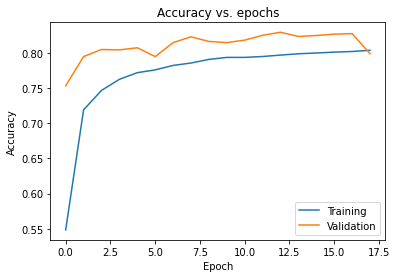

In [28]:
try:
    plt.plot(history_conv.history['accuracy'])
    plt.plot(history_conv.history['val_accuracy'])
except KeyError:
    plt.plot(history_conv.history['acc'])
    plt.plot(history_conv.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

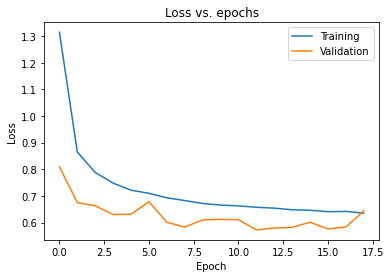

In [29]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [30]:
def get_model_best_epoch(model):
    model.load_weights('checkpoints_best_only/checkpoint')
    return model

def get_model_best_epoch_conv(model_conv):
    model_conv.load_weights('checkpoints_best_only/checkpoint')
    return model_conv

In [31]:
model_best_epoch_cnn = get_model_best_epoch_conv(get_conv_model(train_x[0].shape,0.25,0.001))
print('Model with best epoch weights:')
get_test_accuracy_conv(model_best_epoch_cnn, X_test_grey, y_test)

Model with best epoch weights:
accuracy: 0.811


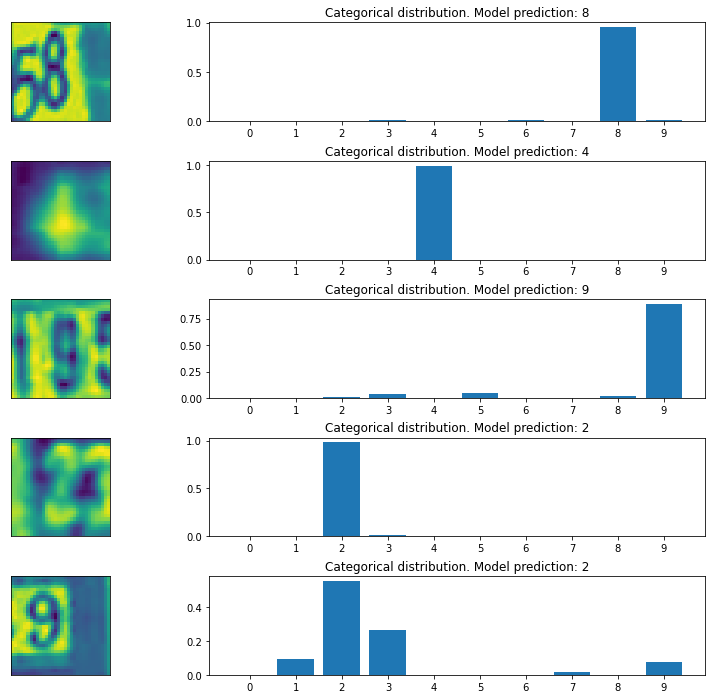

In [32]:
num_test_images = X_test_grey.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = X_test_grey[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

predictions = model_best_epoch_cnn.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")
    
plt.show()